# Neural Structured Learning on Time Series
Two novelties are implemented in this notebook:
* Use the GraphNet framework for time-series in order to discover and exploit degradation trends in the same experiment
* Use implicit reparametrization gradients to learn with SGD the parameters of a gamma distribution instead of an empirical error on the output. This is closer to reality and should work better.


## Load data:

In [1]:
from collections import OrderedDict
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


import pandas as pd

from minigraphnets import Edge,Node, Graph
from datasets.femto_bearing import FEMTOBearingsDataset


not running in colab.


## Loading the train/test sets

In [2]:
femto_dataset = FEMTOBearingsDataset()


training set:
01 0 2_2 1502
05 0 1_1 1802
06 0 2_7 2302
07 1 1_5 1202
08 0 3_2 1139
09 1 2_1 2002
13 1 1_7 911
15 0 1_4 2803

testing set:
16 0 1_3 2302
02 2 2_5 1637


In [3]:
for  ee in range(0,18):
    inds = ee == femto_dataset.eid
    print("e:{ee}, {ss}".format(ee = ee, ss = np.sum(inds)))

e:0, 172
e:1, 1502
e:2, 1637
e:3, 515
e:4, 871
e:5, 1802
e:6, 2302
e:7, 1202
e:8, 1139
e:9, 2002
e:10, 572
e:11, 352
e:12, 797
e:13, 911
e:14, 612
e:15, 2803
e:16, 2302
e:17, 0


In [4]:
#femto_dataset.inds_exp_source.append(14)

In [5]:
#pplot.plot(femto_dataset.yrem_s_raw)
y=femto_dataset.yrem_s_raw[np.array([e in femto_dataset.inds_exp_target for e in femto_dataset.eid])]

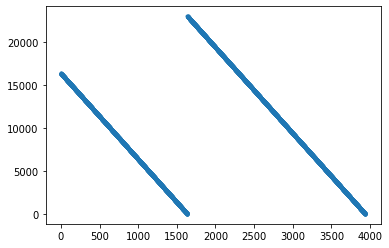

In [6]:
pplot.plot(y,'.')

In [7]:
#femto_dataset.inds_exp_target.append(12)
#femto_dataset.inds_exp_target.append(13)
#femto_dataset.inds_exp_source.remove(13)



In [8]:
#femto_dataset.inds_exp_source.remove(1)
#femto_dataset.inds_exp_target.append(1)

In [9]:
inds_exp_target, inds_exp_source = [femto_dataset.inds_exp_target, femto_dataset.inds_exp_source]

In [10]:
assert(len(set(inds_exp_source).intersection(inds_exp_target)) == 0)

In **GraphNets** some code to make graph inputs for this dataset. The graph encodes in practice the *inductive biases* we are baking into the algorithm. In particular, in this application we are representing the following biases:
* The slow progression of damage may be inferred from arbitrary pairs of points
* Averaging estimates from several points yields better estimates than from fewer ones


In [11]:
%load_ext autoreload
%autoreload 2
from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

# Definition of GraphNet functions and the GraphNet:

In [12]:
from graphnet_utils import GraphNet, GraphNetFunctionFactory
#gtot = GraphNetFunctionFactory(NETWORK_SIZE_GLOBAL = 50, USE_PRENETWORKS = True, EDGE_NODE_STATE_SIZE=15)

# Model Creation:


In [35]:
gn_tot = GraphNetFunctionFactory(network_size_global = 15,
                                 use_prenetworks = True,
                                 edge_node_state_size = 15, 
                                 graph_function_output_activation = "gated_tanh",
                                 nfilts = 20,
                                 nfilts2 = 20,
                                 ksize = 3,
                                 n_conv_blocks=2,
                                 conv_block_activation_type="leaky_relu"
                                )

gn_tot.make_graphnet_comp_blocks(femto_dataset.X[0].shape[0])



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Training

In [36]:
def get_multi_batch_femto(*args, **kwargs):
    new_args = (args[0], femto_dataset)
    return get_multi_batch(*new_args, **kwargs)

In [37]:
curr_data = get_multi_batch_femto(3, source_ds=True,nnodes=5,
                            min_spacing = 1,
                            nseq_range = 100,
                            fixed_spacing_indices=False);
#eval_graphnets(curr_data[0][0].copy())

In [38]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))

class EarlyStopping:
    def __init__(self, patience, loss_handle):
        self.patience = patience
        self.loss_handle = loss_handle
    
    def on_epoch_end(self, epoch):
        break_ = False
        
        if len(self.loss_handle) > 1:
            if np.all(np.min(self.loss_handle[-self.patience:]) > self.min_val):
                print("*** Early stopping. ***")
                break_ = True
                
            else:
                self.min_val = np.min(self.loss_handle)
        else:
            
            self.min_val = self.loss_handle[-1]
        
        return break_
    
class LRScheduler:
    def __init__(self, opt_object, base_lr = 0.001,epoch_decay = 50, decay_rate = 0.95, burnin_epochs = 10):
        self.opt_object = opt_object
        self.opt_object.lr.assign(base_lr)
        if burnin_epochs >0:
            self.opt_object.lr.assign(0)

        self.burnin_epochs = burnin_epochs
        self.base_lr = base_lr
        self.epoch_decay = epoch_decay
        self.decay_rate = decay_rate
        
    def on_epoch_end(self,epoch):
        if epoch <=self.burnin_epochs:
            new_lr = self.base_lr * (epoch / float(self.burnin_epochs))
            print("burn-in:  setting lr to %2.5f"%new_lr)
            self.opt_object.lr.assign(new_lr)

        if epoch >= self.epoch_decay:
            lr = self.opt_object.lr.numpy()
            new_lr = lr * self.decay_rate
            print("lr_decay: setting lr to %2.5f"%new_lr)
            self.opt_object.lr.assign(new_lr)
        

In [39]:
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(20,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, base_lr = learning_rate,
                           epoch_decay = 50,
                           decay_rate = 0.99,
                           burnin_epochs = 10)

In [40]:

#@tf.function
# def eval_graphnets(graph_data_, iterations = 2):
#     graph_out = graph_indep.graph_eval(graph_data_)
#     for iterations in range(iterations):
#         graph_out = gn.graph_eval(graph_out) + graph_out
        
#     return node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)

#@tf.function
def eval_graphnets_loss(graph_curr_, ycurr_, iterations):#,iterations):
    graph_out = graph_indep.graph_eval(graph_curr_)
    
    for iterations in range(iterations):
        graph_out = gn.graph_eval(graph_out) + graph_out

    prob_out = node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)
    loss_vals = -prob_out.log_prob(ycurr_)
    return loss_vals


def graphnet_latent_states(graph_data_, iterations = 2):
    graph_out_tmp = graph_indep.graph_eval(graph_data_)
    lat_states = [graph_out_tmp.copy()]
    for iterations in range(iterations):
        graph_out_tmp = gn.graph_eval(graph_out_tmp) + graph_out
        lat_states.append(graph_out_tmp.copy())
    return lat_states

nnodes: 1, seq_range 300 epoch: 0


100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


loss: 12.784, val_loss 14.589
burn-in:  setting lr to 0.00000


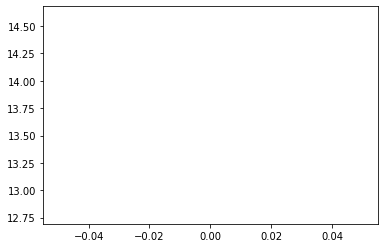

nnodes: 2, seq_range 300 epoch: 1


100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


loss: 12.090, val_loss 13.717
burn-in:  setting lr to 0.00010
nnodes: 5, seq_range 300 epoch: 2


100%|██████████| 8/8 [00:01<00:00,  7.36it/s]


loss: 11.266, val_loss 12.856
burn-in:  setting lr to 0.00020
nnodes: 10, seq_range 300 epoch: 3


100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


loss: 10.862, val_loss 12.432
burn-in:  setting lr to 0.00030
nnodes: 1, seq_range 300 epoch: 4


100%|██████████| 8/8 [00:00<00:00, 18.04it/s]


loss: 12.647, val_loss 14.442
burn-in:  setting lr to 0.00040
nnodes: 2, seq_range 300 epoch: 5


100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


loss: 11.767, val_loss 13.381
burn-in:  setting lr to 0.00050
nnodes: 5, seq_range 300 epoch: 6


100%|██████████| 8/8 [00:01<00:00,  7.86it/s]


loss: 10.664, val_loss 12.243
burn-in:  setting lr to 0.00060
nnodes: 10, seq_range 300 epoch: 7


100%|██████████| 8/8 [00:01<00:00,  4.96it/s]


loss: 9.904, val_loss 11.441
burn-in:  setting lr to 0.00070
nnodes: 1, seq_range 300 epoch: 8


100%|██████████| 8/8 [00:00<00:00, 17.71it/s]


loss: 10.696, val_loss 12.425
burn-in:  setting lr to 0.00080
nnodes: 2, seq_range 300 epoch: 9


100%|██████████| 8/8 [00:00<00:00, 11.89it/s]


loss: 9.733, val_loss 11.379
burn-in:  setting lr to 0.00090
nnodes: 5, seq_range 300 epoch: 10


100%|██████████| 8/8 [00:01<00:00,  7.97it/s]


loss: 9.612, val_loss 11.239
burn-in:  setting lr to 0.00100


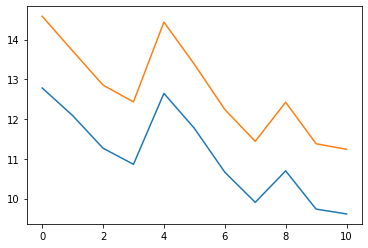

nnodes: 10, seq_range 300 epoch: 11


100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


loss: 9.470, val_loss 10.939
nnodes: 1, seq_range 300 epoch: 12


100%|██████████| 8/8 [00:00<00:00, 17.69it/s]


loss: 10.137, val_loss 11.716
nnodes: 2, seq_range 300 epoch: 13


100%|██████████| 8/8 [00:00<00:00, 11.47it/s]


loss: 9.698, val_loss 11.286
nnodes: 5, seq_range 300 epoch: 14


100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


loss: 9.572, val_loss 11.188
nnodes: 10, seq_range 300 epoch: 15


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


loss: 9.484, val_loss 10.986
nnodes: 1, seq_range 300 epoch: 16


100%|██████████| 8/8 [00:00<00:00, 17.72it/s]


loss: 10.031, val_loss 11.627
nnodes: 2, seq_range 300 epoch: 17


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


loss: 9.672, val_loss 11.249
nnodes: 5, seq_range 300 epoch: 18


100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


loss: 9.526, val_loss 11.119
nnodes: 10, seq_range 300 epoch: 19


100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


loss: 9.429, val_loss 10.957
nnodes: 1, seq_range 300 epoch: 20


100%|██████████| 8/8 [00:00<00:00, 17.65it/s]


loss: 10.078, val_loss 11.660


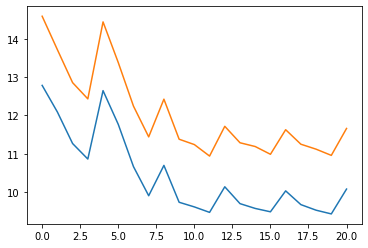

nnodes: 2, seq_range 300 epoch: 21


100%|██████████| 8/8 [00:00<00:00, 11.56it/s]


loss: 9.432, val_loss 10.931
nnodes: 5, seq_range 300 epoch: 22


100%|██████████| 8/8 [00:01<00:00,  8.00it/s]


loss: 9.286, val_loss 10.826
nnodes: 10, seq_range 300 epoch: 23


100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


loss: 8.989, val_loss 10.392
nnodes: 1, seq_range 300 epoch: 24


100%|██████████| 8/8 [00:00<00:00, 17.82it/s]


loss: 9.076, val_loss 10.417
nnodes: 2, seq_range 300 epoch: 25


100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


loss: 9.309, val_loss 10.782
nnodes: 5, seq_range 300 epoch: 26


100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


loss: 8.982, val_loss 10.578
nnodes: 10, seq_range 300 epoch: 27


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


loss: 8.071, val_loss 9.508
nnodes: 1, seq_range 300 epoch: 28


100%|██████████| 8/8 [00:00<00:00, 18.27it/s]


loss: 8.886, val_loss 10.186
nnodes: 2, seq_range 300 epoch: 29


100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


loss: 8.702, val_loss 10.233
nnodes: 5, seq_range 300 epoch: 30


100%|██████████| 8/8 [00:00<00:00,  8.03it/s]


loss: 8.205, val_loss 9.871


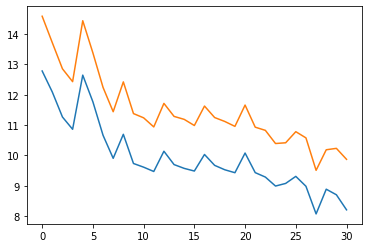

nnodes: 10, seq_range 300 epoch: 31


100%|██████████| 8/8 [00:01<00:00,  5.02it/s]


loss: 7.996, val_loss 9.449
nnodes: 1, seq_range 300 epoch: 32


100%|██████████| 8/8 [00:00<00:00, 18.01it/s]


loss: 7.974, val_loss 9.246
nnodes: 2, seq_range 300 epoch: 33


100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


loss: 9.137, val_loss 10.759
nnodes: 5, seq_range 300 epoch: 34


100%|██████████| 8/8 [00:00<00:00,  8.01it/s]


loss: 8.311, val_loss 9.995
nnodes: 10, seq_range 300 epoch: 35


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


loss: 7.285, val_loss 8.742
nnodes: 1, seq_range 300 epoch: 36


100%|██████████| 8/8 [00:00<00:00, 18.24it/s]


loss: 8.313, val_loss 9.497
nnodes: 2, seq_range 300 epoch: 37


100%|██████████| 8/8 [00:00<00:00, 11.57it/s]


loss: 8.198, val_loss 9.685
nnodes: 5, seq_range 300 epoch: 38


100%|██████████| 8/8 [00:00<00:00,  8.07it/s]


loss: 7.588, val_loss 9.154
nnodes: 10, seq_range 300 epoch: 39


100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


loss: 7.027, val_loss 8.299
nnodes: 1, seq_range 300 epoch: 40


100%|██████████| 8/8 [00:00<00:00, 17.73it/s]


loss: 7.660, val_loss 8.812


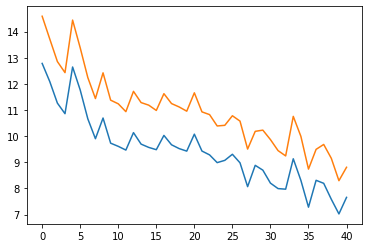

nnodes: 2, seq_range 300 epoch: 41


100%|██████████| 8/8 [00:00<00:00, 11.58it/s]


loss: 8.107, val_loss 9.565
nnodes: 5, seq_range 300 epoch: 42


100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


loss: 6.915, val_loss 8.427
nnodes: 10, seq_range 300 epoch: 43


100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


loss: 7.574, val_loss 8.687
nnodes: 1, seq_range 300 epoch: 44


100%|██████████| 8/8 [00:00<00:00, 18.35it/s]


loss: 7.392, val_loss 8.658
nnodes: 2, seq_range 300 epoch: 45


100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


loss: 9.265, val_loss 10.970
nnodes: 5, seq_range 300 epoch: 46


100%|██████████| 8/8 [00:00<00:00,  8.12it/s]


loss: 7.768, val_loss 9.402
nnodes: 10, seq_range 300 epoch: 47


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


loss: 6.587, val_loss 7.878
nnodes: 1, seq_range 300 epoch: 48


100%|██████████| 8/8 [00:00<00:00, 17.83it/s]


loss: 7.786, val_loss 8.876
nnodes: 2, seq_range 300 epoch: 49


100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


loss: 7.085, val_loss 8.326
nnodes: 5, seq_range 300 epoch: 50


100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


loss: 6.768, val_loss 8.098
lr_decay: setting lr to 0.00099


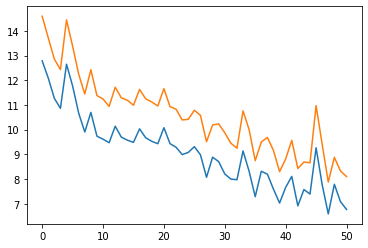

nnodes: 10, seq_range 300 epoch: 51


100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


loss: 6.596, val_loss 7.728
lr_decay: setting lr to 0.00098
nnodes: 1, seq_range 300 epoch: 52


100%|██████████| 8/8 [00:00<00:00, 18.60it/s]


loss: 7.014, val_loss 8.266
lr_decay: setting lr to 0.00097
nnodes: 2, seq_range 300 epoch: 53


100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


loss: 8.029, val_loss 9.592
lr_decay: setting lr to 0.00096
nnodes: 5, seq_range 300 epoch: 54


100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


loss: 6.690, val_loss 8.149
lr_decay: setting lr to 0.00095
nnodes: 10, seq_range 300 epoch: 55


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


loss: 6.928, val_loss 7.891
lr_decay: setting lr to 0.00094
nnodes: 1, seq_range 300 epoch: 56


100%|██████████| 8/8 [00:00<00:00, 18.00it/s]


loss: 7.072, val_loss 8.401
lr_decay: setting lr to 0.00093
nnodes: 2, seq_range 300 epoch: 57


100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


loss: 9.717, val_loss 11.485
lr_decay: setting lr to 0.00092
nnodes: 5, seq_range 300 epoch: 58


100%|██████████| 8/8 [00:00<00:00,  8.07it/s]


loss: 7.976, val_loss 9.662
lr_decay: setting lr to 0.00091
nnodes: 10, seq_range 300 epoch: 59


100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


loss: 6.521, val_loss 7.862
lr_decay: setting lr to 0.00090
nnodes: 1, seq_range 300 epoch: 60


100%|██████████| 8/8 [00:00<00:00, 18.15it/s]


loss: 7.303, val_loss 8.457
lr_decay: setting lr to 0.00090


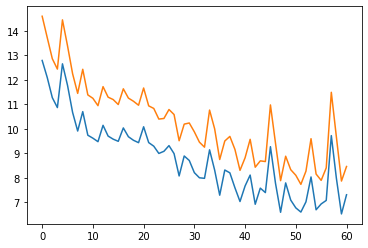

nnodes: 2, seq_range 300 epoch: 61


100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


loss: 7.043, val_loss 8.323
lr_decay: setting lr to 0.00089
nnodes: 5, seq_range 300 epoch: 62


100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


loss: 6.523, val_loss 7.777
lr_decay: setting lr to 0.00088
nnodes: 10, seq_range 300 epoch: 63


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


loss: 6.409, val_loss 7.476
lr_decay: setting lr to 0.00087
nnodes: 1, seq_range 300 epoch: 64


100%|██████████| 8/8 [00:00<00:00, 18.35it/s]


loss: 6.677, val_loss 7.865
lr_decay: setting lr to 0.00086
nnodes: 2, seq_range 300 epoch: 65


100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


loss: 8.335, val_loss 10.004
lr_decay: setting lr to 0.00085
nnodes: 5, seq_range 300 epoch: 66


100%|██████████| 8/8 [00:00<00:00,  8.09it/s]


loss: 6.743, val_loss 8.188
lr_decay: setting lr to 0.00084
nnodes: 10, seq_range 300 epoch: 67


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


loss: 6.177, val_loss 7.207
lr_decay: setting lr to 0.00083
nnodes: 1, seq_range 300 epoch: 68


100%|██████████| 8/8 [00:00<00:00, 18.37it/s]


loss: 6.627, val_loss 7.796
lr_decay: setting lr to 0.00083
nnodes: 2, seq_range 300 epoch: 69


100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


loss: 8.125, val_loss 9.789
lr_decay: setting lr to 0.00082
nnodes: 5, seq_range 300 epoch: 70


100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


loss: 6.593, val_loss 7.982
lr_decay: setting lr to 0.00081


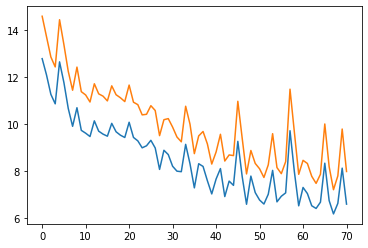

nnodes: 10, seq_range 300 epoch: 71


100%|██████████| 8/8 [00:01<00:00,  4.76it/s]


loss: 6.102, val_loss 7.088
lr_decay: setting lr to 0.00080
nnodes: 1, seq_range 300 epoch: 72


100%|██████████| 8/8 [00:00<00:00, 18.17it/s]


loss: 6.566, val_loss 7.777
lr_decay: setting lr to 0.00079
nnodes: 2, seq_range 300 epoch: 73


100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


loss: 8.190, val_loss 9.862
lr_decay: setting lr to 0.00079
nnodes: 5, seq_range 300 epoch: 74


100%|██████████| 8/8 [00:01<00:00,  7.68it/s]


loss: 6.593, val_loss 7.964
lr_decay: setting lr to 0.00078
nnodes: 10, seq_range 300 epoch: 75


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


loss: 6.011, val_loss 7.044
lr_decay: setting lr to 0.00077
nnodes: 1, seq_range 300 epoch: 76


100%|██████████| 8/8 [00:00<00:00, 18.40it/s]


loss: 6.491, val_loss 7.675
lr_decay: setting lr to 0.00076
nnodes: 2, seq_range 300 epoch: 77


100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


loss: 7.962, val_loss 9.658
lr_decay: setting lr to 0.00075
nnodes: 5, seq_range 300 epoch: 78


100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


loss: 6.489, val_loss 7.804
lr_decay: setting lr to 0.00075
nnodes: 10, seq_range 300 epoch: 79


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


loss: 5.962, val_loss 7.012
lr_decay: setting lr to 0.00074
nnodes: 1, seq_range 300 epoch: 80


100%|██████████| 8/8 [00:00<00:00, 18.36it/s]


loss: 6.443, val_loss 7.656
lr_decay: setting lr to 0.00073


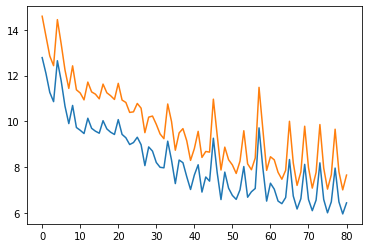

nnodes: 2, seq_range 300 epoch: 81


100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


loss: 7.923, val_loss 9.627
lr_decay: setting lr to 0.00072
nnodes: 5, seq_range 300 epoch: 82


100%|██████████| 8/8 [00:01<00:00,  7.95it/s]


loss: 6.489, val_loss 7.795
lr_decay: setting lr to 0.00072
nnodes: 10, seq_range 300 epoch: 83


100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


loss: 5.910, val_loss 6.986
lr_decay: setting lr to 0.00071
nnodes: 1, seq_range 300 epoch: 84


100%|██████████| 8/8 [00:00<00:00, 18.08it/s]


loss: 6.416, val_loss 7.623
lr_decay: setting lr to 0.00070
nnodes: 2, seq_range 300 epoch: 85


100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


loss: 7.873, val_loss 9.583
lr_decay: setting lr to 0.00070
nnodes: 5, seq_range 300 epoch: 86


100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


loss: 6.529, val_loss 7.828
lr_decay: setting lr to 0.00069
nnodes: 10, seq_range 300 epoch: 87


100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


loss: 5.838, val_loss 6.981
lr_decay: setting lr to 0.00068
nnodes: 1, seq_range 300 epoch: 88


100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


loss: 6.380, val_loss 7.592
lr_decay: setting lr to 0.00068
nnodes: 2, seq_range 300 epoch: 89


100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


loss: 7.517, val_loss 9.226
lr_decay: setting lr to 0.00067
nnodes: 5, seq_range 300 epoch: 90


100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


loss: 6.383, val_loss 7.587
lr_decay: setting lr to 0.00066


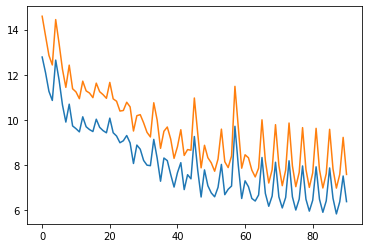

nnodes: 10, seq_range 300 epoch: 91


100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


loss: 5.776, val_loss 6.919
lr_decay: setting lr to 0.00066
nnodes: 1, seq_range 300 epoch: 92


100%|██████████| 8/8 [00:00<00:00, 16.93it/s]


loss: 6.328, val_loss 7.575
lr_decay: setting lr to 0.00065
nnodes: 2, seq_range 300 epoch: 93


100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


loss: 7.536, val_loss 9.258
lr_decay: setting lr to 0.00064
nnodes: 5, seq_range 300 epoch: 94


100%|██████████| 8/8 [00:00<00:00,  8.08it/s]


loss: 6.391, val_loss 7.582
lr_decay: setting lr to 0.00064
nnodes: 10, seq_range 300 epoch: 95


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


loss: 5.688, val_loss 6.848
lr_decay: setting lr to 0.00063
nnodes: 1, seq_range 300 epoch: 96


100%|██████████| 8/8 [00:00<00:00, 18.16it/s]


loss: 6.285, val_loss 7.553
lr_decay: setting lr to 0.00062
nnodes: 2, seq_range 300 epoch: 97


100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


loss: 7.363, val_loss 9.079
lr_decay: setting lr to 0.00062
nnodes: 5, seq_range 300 epoch: 98


100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


loss: 6.347, val_loss 7.514
lr_decay: setting lr to 0.00061
nnodes: 10, seq_range 300 epoch: 99


100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


loss: 5.615, val_loss 6.797
lr_decay: setting lr to 0.00061
nnodes: 1, seq_range 300 epoch: 100


100%|██████████| 8/8 [00:00<00:00, 18.54it/s]


loss: 6.227, val_loss 7.513
lr_decay: setting lr to 0.00060


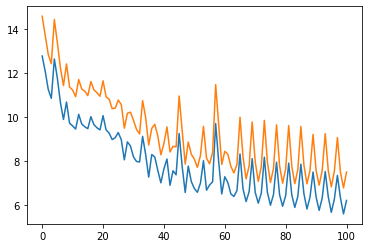

nnodes: 2, seq_range 300 epoch: 101


100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


loss: 7.177, val_loss 8.884
lr_decay: setting lr to 0.00059
nnodes: 5, seq_range 300 epoch: 102


100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


loss: 6.258, val_loss 7.413
lr_decay: setting lr to 0.00059
nnodes: 10, seq_range 300 epoch: 103


100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


loss: 5.554, val_loss 6.744
lr_decay: setting lr to 0.00058
nnodes: 1, seq_range 300 epoch: 104


100%|██████████| 8/8 [00:00<00:00, 18.25it/s]


loss: 6.167, val_loss 7.465
lr_decay: setting lr to 0.00058
nnodes: 2, seq_range 300 epoch: 105


100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


loss: 7.111, val_loss 8.822
lr_decay: setting lr to 0.00057
nnodes: 5, seq_range 300 epoch: 106


100%|██████████| 8/8 [00:01<00:00,  8.00it/s]


loss: 6.203, val_loss 7.356
lr_decay: setting lr to 0.00056
nnodes: 10, seq_range 300 epoch: 107


100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


loss: 5.500, val_loss 6.693
lr_decay: setting lr to 0.00056
nnodes: 1, seq_range 300 epoch: 108


100%|██████████| 8/8 [00:00<00:00, 18.14it/s]


loss: 6.132, val_loss 7.438
lr_decay: setting lr to 0.00055
nnodes: 2, seq_range 300 epoch: 109


100%|██████████| 8/8 [00:00<00:00, 11.72it/s]


loss: 7.098, val_loss 8.827
lr_decay: setting lr to 0.00055
nnodes: 5, seq_range 300 epoch: 110


100%|██████████| 8/8 [00:00<00:00,  8.06it/s]


loss: 6.173, val_loss 7.338
lr_decay: setting lr to 0.00054


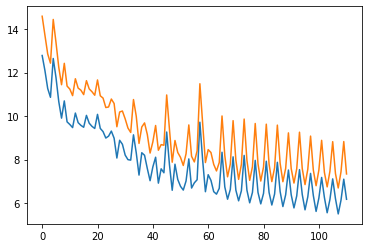

nnodes: 10, seq_range 300 epoch: 111


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


loss: 5.474, val_loss 6.696
lr_decay: setting lr to 0.00054
nnodes: 1, seq_range 300 epoch: 112


100%|██████████| 8/8 [00:00<00:00, 18.56it/s]


loss: 6.104, val_loss 7.416
lr_decay: setting lr to 0.00053
nnodes: 2, seq_range 300 epoch: 113


100%|██████████| 8/8 [00:00<00:00, 11.92it/s]


loss: 7.024, val_loss 8.749
lr_decay: setting lr to 0.00053
nnodes: 5, seq_range 300 epoch: 114


100%|██████████| 8/8 [00:01<00:00,  7.92it/s]


loss: 6.136, val_loss 7.299
lr_decay: setting lr to 0.00052
nnodes: 10, seq_range 300 epoch: 115


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


loss: 5.456, val_loss 6.698
lr_decay: setting lr to 0.00052
nnodes: 1, seq_range 300 epoch: 116


100%|██████████| 8/8 [00:00<00:00, 18.19it/s]


loss: 6.069, val_loss 7.397
lr_decay: setting lr to 0.00051
nnodes: 2, seq_range 300 epoch: 117


100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


loss: 6.971, val_loss 8.699
lr_decay: setting lr to 0.00050
nnodes: 5, seq_range 300 epoch: 118


100%|██████████| 8/8 [00:00<00:00,  8.04it/s]


loss: 6.083, val_loss 7.242
lr_decay: setting lr to 0.00050
nnodes: 10, seq_range 300 epoch: 119


100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


loss: 5.419, val_loss 6.652
lr_decay: setting lr to 0.00049
nnodes: 1, seq_range 300 epoch: 120


100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


loss: 6.060, val_loss 7.394
lr_decay: setting lr to 0.00049


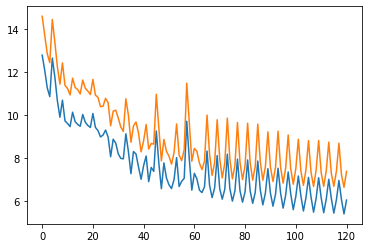

nnodes: 2, seq_range 300 epoch: 121


100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


loss: 7.007, val_loss 8.746
lr_decay: setting lr to 0.00048
nnodes: 5, seq_range 300 epoch: 122


100%|██████████| 8/8 [00:01<00:00,  7.92it/s]


loss: 6.080, val_loss 7.257
lr_decay: setting lr to 0.00048
nnodes: 10, seq_range 300 epoch: 123


100%|██████████| 8/8 [00:01<00:00,  5.01it/s]


loss: 5.418, val_loss 6.676
lr_decay: setting lr to 0.00048
nnodes: 1, seq_range 300 epoch: 124


100%|██████████| 8/8 [00:00<00:00, 17.90it/s]


loss: 6.043, val_loss 7.374
lr_decay: setting lr to 0.00047
nnodes: 2, seq_range 300 epoch: 125


100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


loss: 6.997, val_loss 8.741
lr_decay: setting lr to 0.00047
nnodes: 5, seq_range 300 epoch: 126


100%|██████████| 8/8 [00:01<00:00,  7.92it/s]


loss: 6.068, val_loss 7.271
lr_decay: setting lr to 0.00046
nnodes: 10, seq_range 300 epoch: 127


100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


loss: 5.450, val_loss 6.742
lr_decay: setting lr to 0.00046
nnodes: 1, seq_range 300 epoch: 128


100%|██████████| 8/8 [00:00<00:00, 18.65it/s]


loss: 6.053, val_loss 7.382
lr_decay: setting lr to 0.00045
nnodes: 2, seq_range 300 epoch: 129


100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


loss: 7.048, val_loss 8.791
lr_decay: setting lr to 0.00045
nnodes: 5, seq_range 300 epoch: 130


100%|██████████| 8/8 [00:00<00:00,  8.05it/s]


loss: 6.087, val_loss 7.345
lr_decay: setting lr to 0.00044


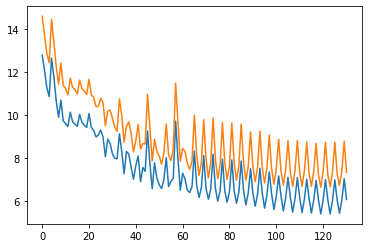

nnodes: 10, seq_range 300 epoch: 131


100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


loss: 5.505, val_loss 6.818
lr_decay: setting lr to 0.00044
nnodes: 1, seq_range 300 epoch: 132


100%|██████████| 8/8 [00:00<00:00, 18.67it/s]


loss: 6.114, val_loss 7.441
lr_decay: setting lr to 0.00043
nnodes: 2, seq_range 300 epoch: 133


100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


loss: 7.184, val_loss 8.937
lr_decay: setting lr to 0.00043
nnodes: 5, seq_range 300 epoch: 134


100%|██████████| 8/8 [00:00<00:00,  8.06it/s]


loss: 6.182, val_loss 7.521
lr_decay: setting lr to 0.00043
nnodes: 10, seq_range 300 epoch: 135


100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


loss: 5.613, val_loss 6.946
lr_decay: setting lr to 0.00042
nnodes: 1, seq_range 300 epoch: 136


100%|██████████| 8/8 [00:00<00:00, 18.21it/s]


loss: 6.301, val_loss 7.627
lr_decay: setting lr to 0.00042
nnodes: 2, seq_range 300 epoch: 137


100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


loss: 7.321, val_loss 9.081
lr_decay: setting lr to 0.00041
nnodes: 5, seq_range 300 epoch: 138


100%|██████████| 8/8 [00:00<00:00,  8.05it/s]


loss: 6.424, val_loss 7.843
lr_decay: setting lr to 0.00041
nnodes: 10, seq_range 300 epoch: 139


100%|██████████| 8/8 [00:01<00:00,  4.95it/s]

loss: 5.761, val_loss 7.101
lr_decay: setting lr to 0.00040
*** Early stopping. ***


In [41]:
epochs = 500
nbatch  = 300

val_pct = 0.1
fixed_spacing_indices = False;
nnodes_schedule =     [1,2,5,10] #[10,10,1,2,5]#2,2,3,3]#,1,2,2,1,1,3,3]
nseq_range_schedule = [300];
min_spacing_schedule =[10];
iterations_schedule = [5]

#nnodes_schedule = [1,2,4,4,5,10,5]
#nseq_range_schedule = [2,5,15,15,20,50,30]
#min_spacing_schedule = [1,1,1,1,1,1]
#iterations_schedule =  [3,2,3,3,4]

#nnodes_schedule = [1,2,5]
#nseq_range_schedule = [20]
#min_spacing_schedule = [1,1,1]
#iterations_schedule = [3,3,3]
from tqdm import tqdm
import time


    
for i in range(0,epochs):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch_femto(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in tqdm(curr_data):
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            #print(graph_curr)
            #def eval_graphnets_loss(graph_curr_, ycurr_,iterations):
            prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations, node_index_to_use=0)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            #ycurr_t = y_curr[np.newaxis].T
            #ycurr_t = tf.Variable(ycurr_t)i
            #loss_vals=  eval_graphnets_loss(graph_curr.copy(), ycurr_t, tf.constant(iterations))
            
            all_weights =gn_tot.weights() 
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]            
            opt.apply_gradients(zip(grads_filt, all_weights_filt))

            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if (early_stop.on_epoch_end(epoch) )and (epoch  > 20):
        break
        
    if (epoch)%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()

In [42]:
g = curr_data[0][0]


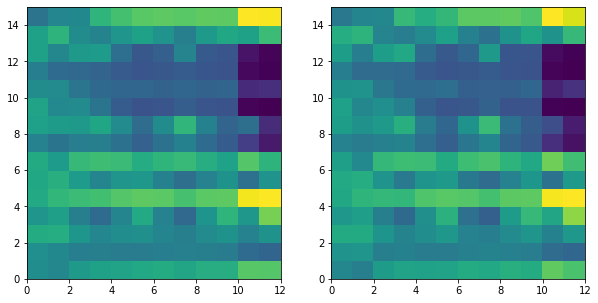

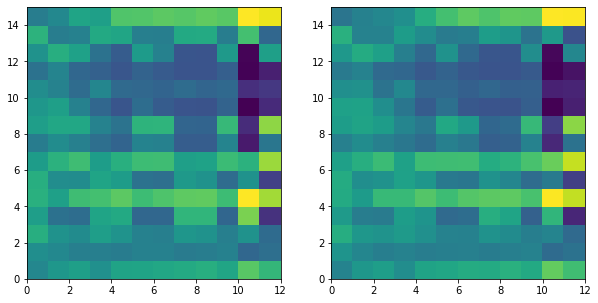

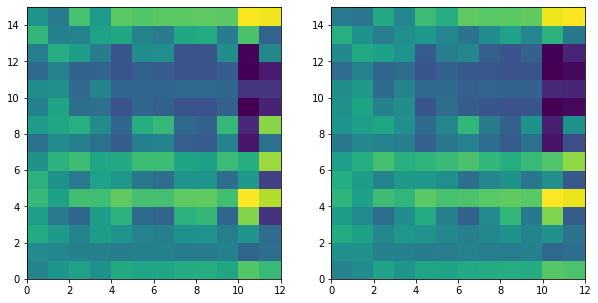

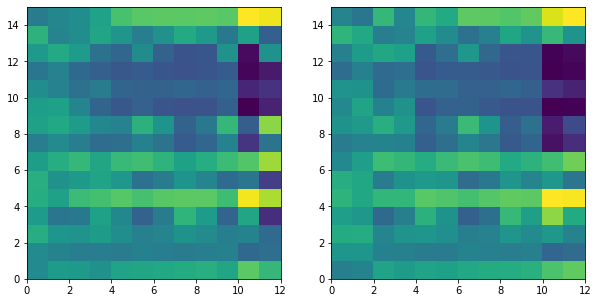

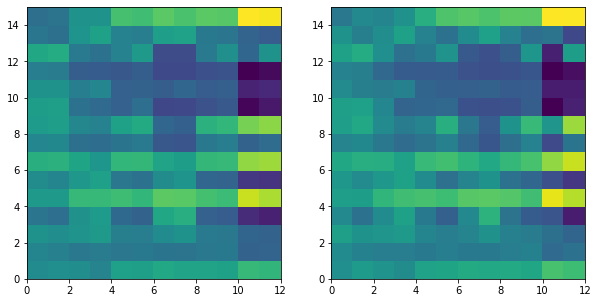

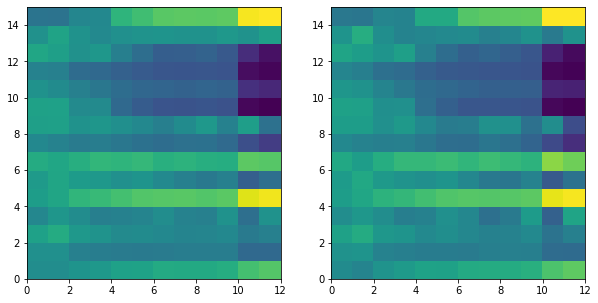

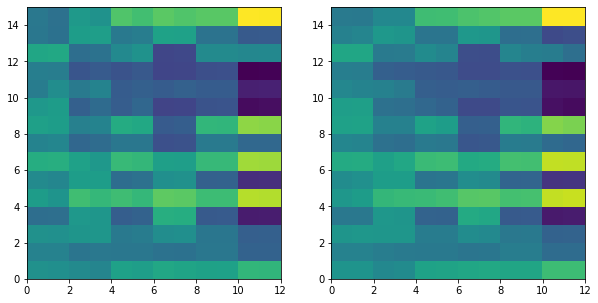

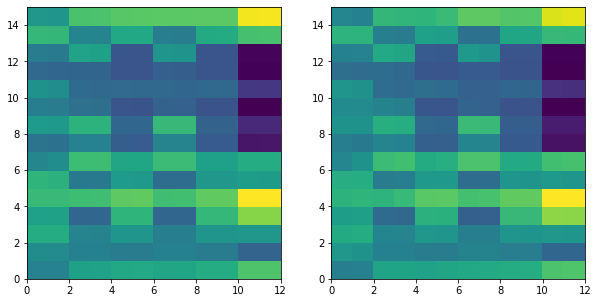

In [45]:
def graphnet_latent_states(graph_data_, iterations = 2):
    graph_out_tmp = gn_tot.graph_indep.graph_eval(graph_data_)
    lat_states = [graph_out_tmp]
    for iterations in range(iterations):
        graph_out_tmp = gn_tot.core.graph_eval(graph_out_tmp) + graph_out_tmp
        lat_states.append(graph_out_tmp)
    return lat_states

curr_data = get_multi_batch_femto(2, source_ds=True,nnodes=5,
                            min_spacing = 20,
                            nseq_range = 100,
                            fixed_spacing_indices=True);
c = curr_data[0][0]


for c in curr_data:
    c = c[0]
    c = graphnet_latent_states(c.copy(), iterations =5)
    pplot.figure(figsize = (10,5)) 
    pplot.subplot(1,2,1)
    pplot.pcolor(np.vstack([c_.nodes[-1].node_attr_tensor.numpy() for c_ in c]).T)
    pplot.subplot(1,2,2)
    pplot.pcolor(np.vstack([c_.nodes[0].node_attr_tensor.numpy() for c_ in c]).T)
    pplot.show()
    

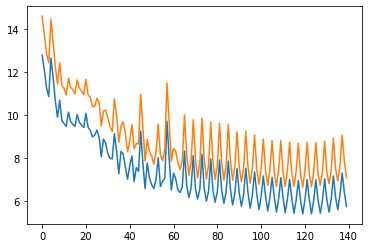

In [46]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


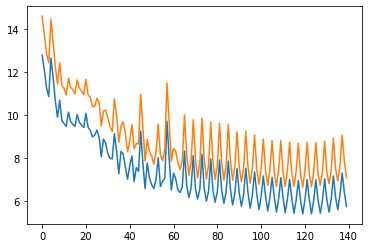

In [47]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


10


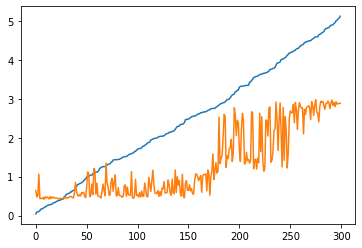

In [48]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)
prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations)

ids_sort = np.argsort(y_curr);
pplot.plot(y_curr[ids_sort])
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

In [49]:
inds_exp_target

[16, 2]

In [50]:
# Inspect the learned embeddings for different experiments. See if some of them cluster.
def get_exp_dat(exp_num, keep_from_end):
    ids = np.argmax(femto_dataset.eid_oh,1) == exp_num
    
    return femto_dataset.X[ids][-keep_from_end:,:,:],femto_dataset.yrem_norm[ids][-keep_from_end:]
#embs = graph_indep.node_function(get_exp_dat(1))
#graph_indep.node_function.summary()

keep_from_end = 100;
all_embs = []
exp_inds_plot = []
yfrom_ends = []
for ee in [*inds_exp_source, *inds_exp_target]:
    g, gg = get_exp_dat(ee, keep_from_end)
    
    e = gn_tot.graph_indep.node_function([np.zeros([g.shape[0],1]).astype("float32") ,g])
    all_embs.append(e)
    exp_inds_plot.append([ee]*keep_from_end)
    yfrom_ends.append(gg)
    
    
exp_inds_plot = np.hstack(exp_inds_plot)
yfrom_ends = np.hstack(yfrom_ends)
#graph_indep.node_function.inputs

#graph_indep.node_function()


In [51]:
istarget = np.zeros_like(exp_inds_plot)
istarget[[e_ for e_,e in enumerate(exp_inds_plot) if e in inds_exp_target]] = 1


In [52]:
all_embs_ = np.vstack([a.numpy() for a in all_embs])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=4);
tsne = TSNE(n_components=2);
tsne= tsne.fit_transform(all_embs_)
#pplot.scatter(epca[:,0],epca[:,1])


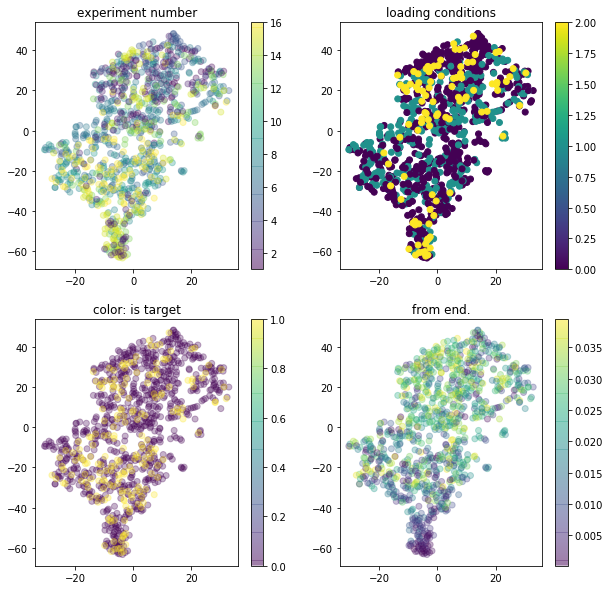

In [53]:
pplot.figure(figsize = (10,10))
pplot.subplot(2,2,1)
pplot.scatter(tsne[:,0], tsne[:,1],c = exp_inds_plot, alpha = 0.3)
pplot.title("experiment number")
pplot.colorbar()
pplot.subplot(2,2,2)
pplot.scatter(tsne[:,0], tsne[:,1],c = [femto_dataset.exp_to_cond_dict[k] for k in exp_inds_plot])
pplot.title("loading conditions")
pplot.colorbar()
pplot.subplot(2,2,3)
pplot.scatter(tsne[:,0], tsne[:,1], c = istarget, alpha = 0.3)
pplot.title("color: is target")
pplot.colorbar()
pplot.subplot(2,2,4)
pplot.scatter(tsne[:,0], tsne[:,1], c = yfrom_ends, alpha = 0.3)
pplot.title("from end.")
pplot.colorbar()
pplot.show()


In [54]:
#femto_dataset.inds_exp_target.remove(4)

In [55]:
all_non_source_experiments = [e for e in range(17) if e not in femto_dataset.inds_exp_source]
all_non_source_experiments

[0, 2, 3, 4, 10, 11, 12, 14, 16]

In [56]:

def plot_experiments(experiments_to_plot, figsize = None):
    #training = inds_exp_source
    nsampled = 500

    if figsize is None:
        pplot.figure(figsize = (15,10), dpi = 300)
    else:
        pplot.figure(figsize = figsize , dpi = 300)
    nnodes_list = [1,5,20]#,3,5]
    nseq_len = [300,300,300]
    minspacing= [10,10,10]
    gnsteps  = [ 5,5,5]
    
    normalization_factor_time = femto_dataset.normalization_factor_time
    kk = 0;
    for ee in experiments_to_plot:
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
            #ee = training[0]
            try:
                graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                                 yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                                 nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                                 nseq_range=nseq_)
            except:
                next
            probs = gn_tot.eval_graphnets(graphs,gnsteps_,eval_mode="safe")
            #eval_graphnets()
            ids_sorted = np.argsort(y_times)
            time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
            time_grid = np.linspace(np.min(y_times), 60000./normalization_factor_time, 150)
            #time_grid = np.linspace(np.min(y_times),3.5, 150);

            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T

            y_times_sorted = y_times[ids_sorted];
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.5, cmap = "gray")
            pplot.plot(y_times_sorted  *normalization_factor_time)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]

            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            pplot.plot(q90*femto_dataset.normalization_factor_time,'C1-.', alpha = 0.4)
            pplot.ylim(0,75000)
            pplot.xlabel("Sample")
            pplot.ylabel("Time to failure [s]")

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))

            title = "Experiment %i\n Observations:%i \nnll:%2.3f"%(ee,nnodes,nll)
            pplot.title(title)
            kk+=1
            #p_y.shape
            #pplot.show()
    pplot.subplots_adjust(hspace = 0.65, wspace = 0.5)
    pplot.show()
    


In [57]:
def get_indices_for_bootstrap(nsamples, min_idx_last_node, seq_length , nnodes_tot, min_spacing = 5):
    """
    returns indices for a given number of nodes from past.
    First selects an index larger than a given minimum index and then samples 
    a set of nodes (given number) with indices smaller that this index.
    Used in bootstrap-type evaluation.
    Only a random subset of nodes is used for every evaluation and result is averaged.
    """
    inds_last_node = np.random.choice(range(min_idx_last_node,seq_length-min_idx),nsamples, replace = True)+ min_idx
    all_inds = []
    for i in range(nsamples):
        
        new_inds = np.random.choice(range(0,inds_last_node[i], min_spacing),nnodes_tot, replace = False)
        all_inds.append(new_inds)
        
    return all_inds

        
        

In [28]:
max_idx = 300
nsamples = 500
ii = get_indices_for_bootstrap(nsamples,50,300,nnodes_tot = 10,min_spacing = 5)
z = np.zeros([nsamples,max_idx])
for z_ , i_ in zip(z[:], ii):
    
    z_[i_] = 1
    
pplot.pcolor(z)
pplot.pcolor(z[np.argsort(np.max(np.array(ii),1))])
    

NameError: name 'min_idx' is not defined

In [29]:
#pplot.hist(np.where(z==1)[1])
#pplot.pcolor(z[np.argsort(np.where(z==1)[1])])


In [ ]:
#print("target")
#plot_experiments(inds_exp_target)
#pplot.savefig("graphnet_result_testset.png")
print("source:")
plot_experiments(inds_exp_source[0:3])
#pplot.savefig("graphnet_result_trainset.png")

source:


In [ ]:
for s in range(0,len(all_non_source_experiments)):
    try:
        plot_experiments([all_non_source_experiments[s]], figsize = (7.5,2.5))
    except:
        None
    

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

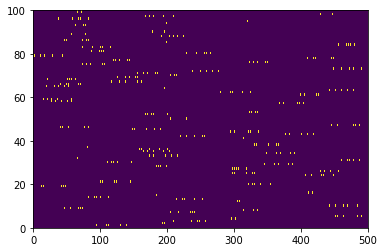

In [65]:
#get_data_from_exp()
#femto_dataset.X
inds_samples = get_indices(100,500,nseq_range = 50, nmin_idx_diff=3, npoints_per_seq=5, fixed_spacing_indices=False)
#help(get_indices)
#np.zeros()
#pplot.pcolor(inds_samples)
z=  np.zeros([100,500]);
for z_, i_ in zip(z[:],inds_samples):
    z_[i_]  = 1
    
pplot.pcolor(z)
np.sum(z,1)

In [96]:
%matplotlib qt5
#gn_tot.save("SavedGraphNet")
from matplotlib import patches

        
def plot_between_points(from_, to_, **kw_points):
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    
    kw_points.update({"arrowstyle" : style})
    a = patches.FancyArrowPatch((from_.center[0],from_.center[1]), (to_.center[0], to_.center[1]),
                                 connectionstyle="arc3,rad=.5", **kw_points)
    
    return a

def graph_patches(g, index_to_plot = 0, derive_node_values = None, xlims = [0,1], sc = 0.1, node_coords = None,node_radious = 0.1,
                  edge_value_to_color = lambda ev : None,
                  node_value_to_color = lambda nc : None, 
                  cmap = "copper", node_text = True):
    
        
    nodes_dict = {n:n.node_attr_tensor[index_to_plot,...] for n in g.nodes}
    edges_dict = {e:e.edge_tensor[index_to_plot,...] for e in g.edges}
    
    edge_cmap  =pplot.get_cmap(cmap)
    node_cmap  =pplot.get_cmap(cmap)
    # I use a dictionary so I can resolve connectivity easier.
    #if derive_node_values is None:
    #    node_values = [1.*sc for k in nodes_dict.values()]
    
    node_colors = [] 
    if node_coords is None:
        node_coords_x = [float(k)*0.1-xlims[0]+node_radious for k in range(0, len(nodes_dict))]
        node_coords_y = [0. for kk in node_coords_x];
    
    
    # node patches:
    node_patches = {};
    for n,ncx,ncy in zip(nodes_dict.keys(),node_coords_x, node_coords_y):
        node_color = node_value_to_color(nodes_dict[n])
        node_color_rgb = node_cmap(node_color)
        node_patch_val = {n:patches.Circle((ncx,ncy,0), node_radious, color = node_color_rgb)}
        node_patches.update(node_patch_val)
        
        
        
    # edge patches:
    edge_patches = {};
    for ek, ev in zip(edges_dict.keys(), edges_dict.values()):
        
        patch_from = node_patches[ek.node_from]
        patch_to = node_patches[ek.node_to]
        
        edge_color_val = edge_value_to_color(ev)
        if edge_color_val is not None:
            edge_color_val = edge_cmap(edge_color_val)
            
        edge_patches.update({ek : plot_between_points(patch_from, patch_to, color = edge_color_val)})
    
        
    # make node patches:
    return [p_ for p_ in node_patches.values()] , [ep for ep in edge_patches.values()]


graph = curr_data[0][0];
p,e = graph_patches(graph,0, sc = 0.03,
                    edge_value_to_color = lambda ev : np.linalg.norm(ev),
                    node_value_to_color = lambda vv : np.max(np.abs(vv)),
                    
                    node_radious = 0.02, cmap = "Blues")

node_labels = ["n%i"%i for i,n in enumerate(graph.nodes)]

def get_from_to_index(graph, edge):
    return (graph.nodes.index(edge.node_from), graph.nodes.index(edge.node_to))

edge_labels = ["e%i%i"%get_from_to_index(graph,e)  for e in graph.edges]
fig, ax = pplot.subplots(figsize = (10,10))
ax.set_xlim([0,1])
ax.set_ylim([-0.5,0.5])


for p_ in p:
    ax.add_patch(p_)
    
for p_,nl in zip(p, node_labels):
    ax.text(p_.center[0], p_.center[1]+0.05, nl)

for e_ in e:
    ax.add_patch(e_)



In [101]:
e_.clipbox.corners()

array([[125.  , 105.82],
       [125.  , 846.56],
       [900.  , 105.82],
       [900.  , 846.56]])

In [93]:
get_from_to_index(graph, graph.edges[2])


(1, 2)

In [90]:
graph.edges[0].no

In [53]:
curr_data[0][0]

In [32]:
print("training set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_source]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
print("\ntesting set:")
for k,m in [(i,exp_to_cond_dict[i]) for i in inds_exp_target]:
    print("%02i %i %s %i"%(k,m, all_files[k][5:8],counts_dict[k]))
    
#plot_experiments([10])


training set:


NameError: name 'exp_to_cond_dict' is not defined

In [58]:
n = Node()
Graph(n,e)

TypeError: __init__() missing 1 required positional argument: 'node_attr_tensor'

In [59]:
#plot_experiments(targets[0:2])
plot_experiments([5,2,16])


ValueError: num must be 1 <= num <= 0, not 1

<Figure size 9000x6000 with 0 Axes>

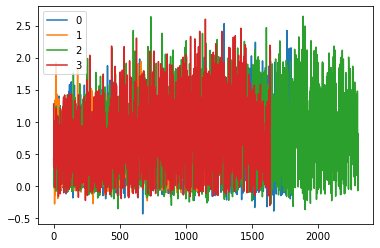

In [225]:
for m in range(len(inds_exp_target)):
    x_ = X[np.argmax(eid_oh,axis=-1) == inds_exp_target[m]]
    v = graph_indep.node_function.predict([np.zeros([x_.shape[0],1]),x_], batch_size = 100)
    pplot.plot(v[:,3], label = m)
    
pplot.legend()

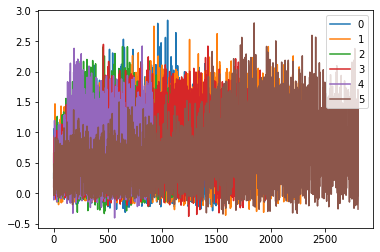

In [226]:
for m in range(len(inds_exp_source)):
    x_ = X[np.argmax(eid_oh,axis=-1) == inds_exp_source[m]]
    v = graph_indep.node_function.predict([np.zeros([x_.shape[0],1]),x_], batch_size = 100)
    pplot.plot(v[:,3], label = m)
pplot.legend()

In [48]:
plot_experiments(inds_exp_target)
#plot_experiments(inds_exp_target[2:])


NameError: name 'plot_experiments' is not defined

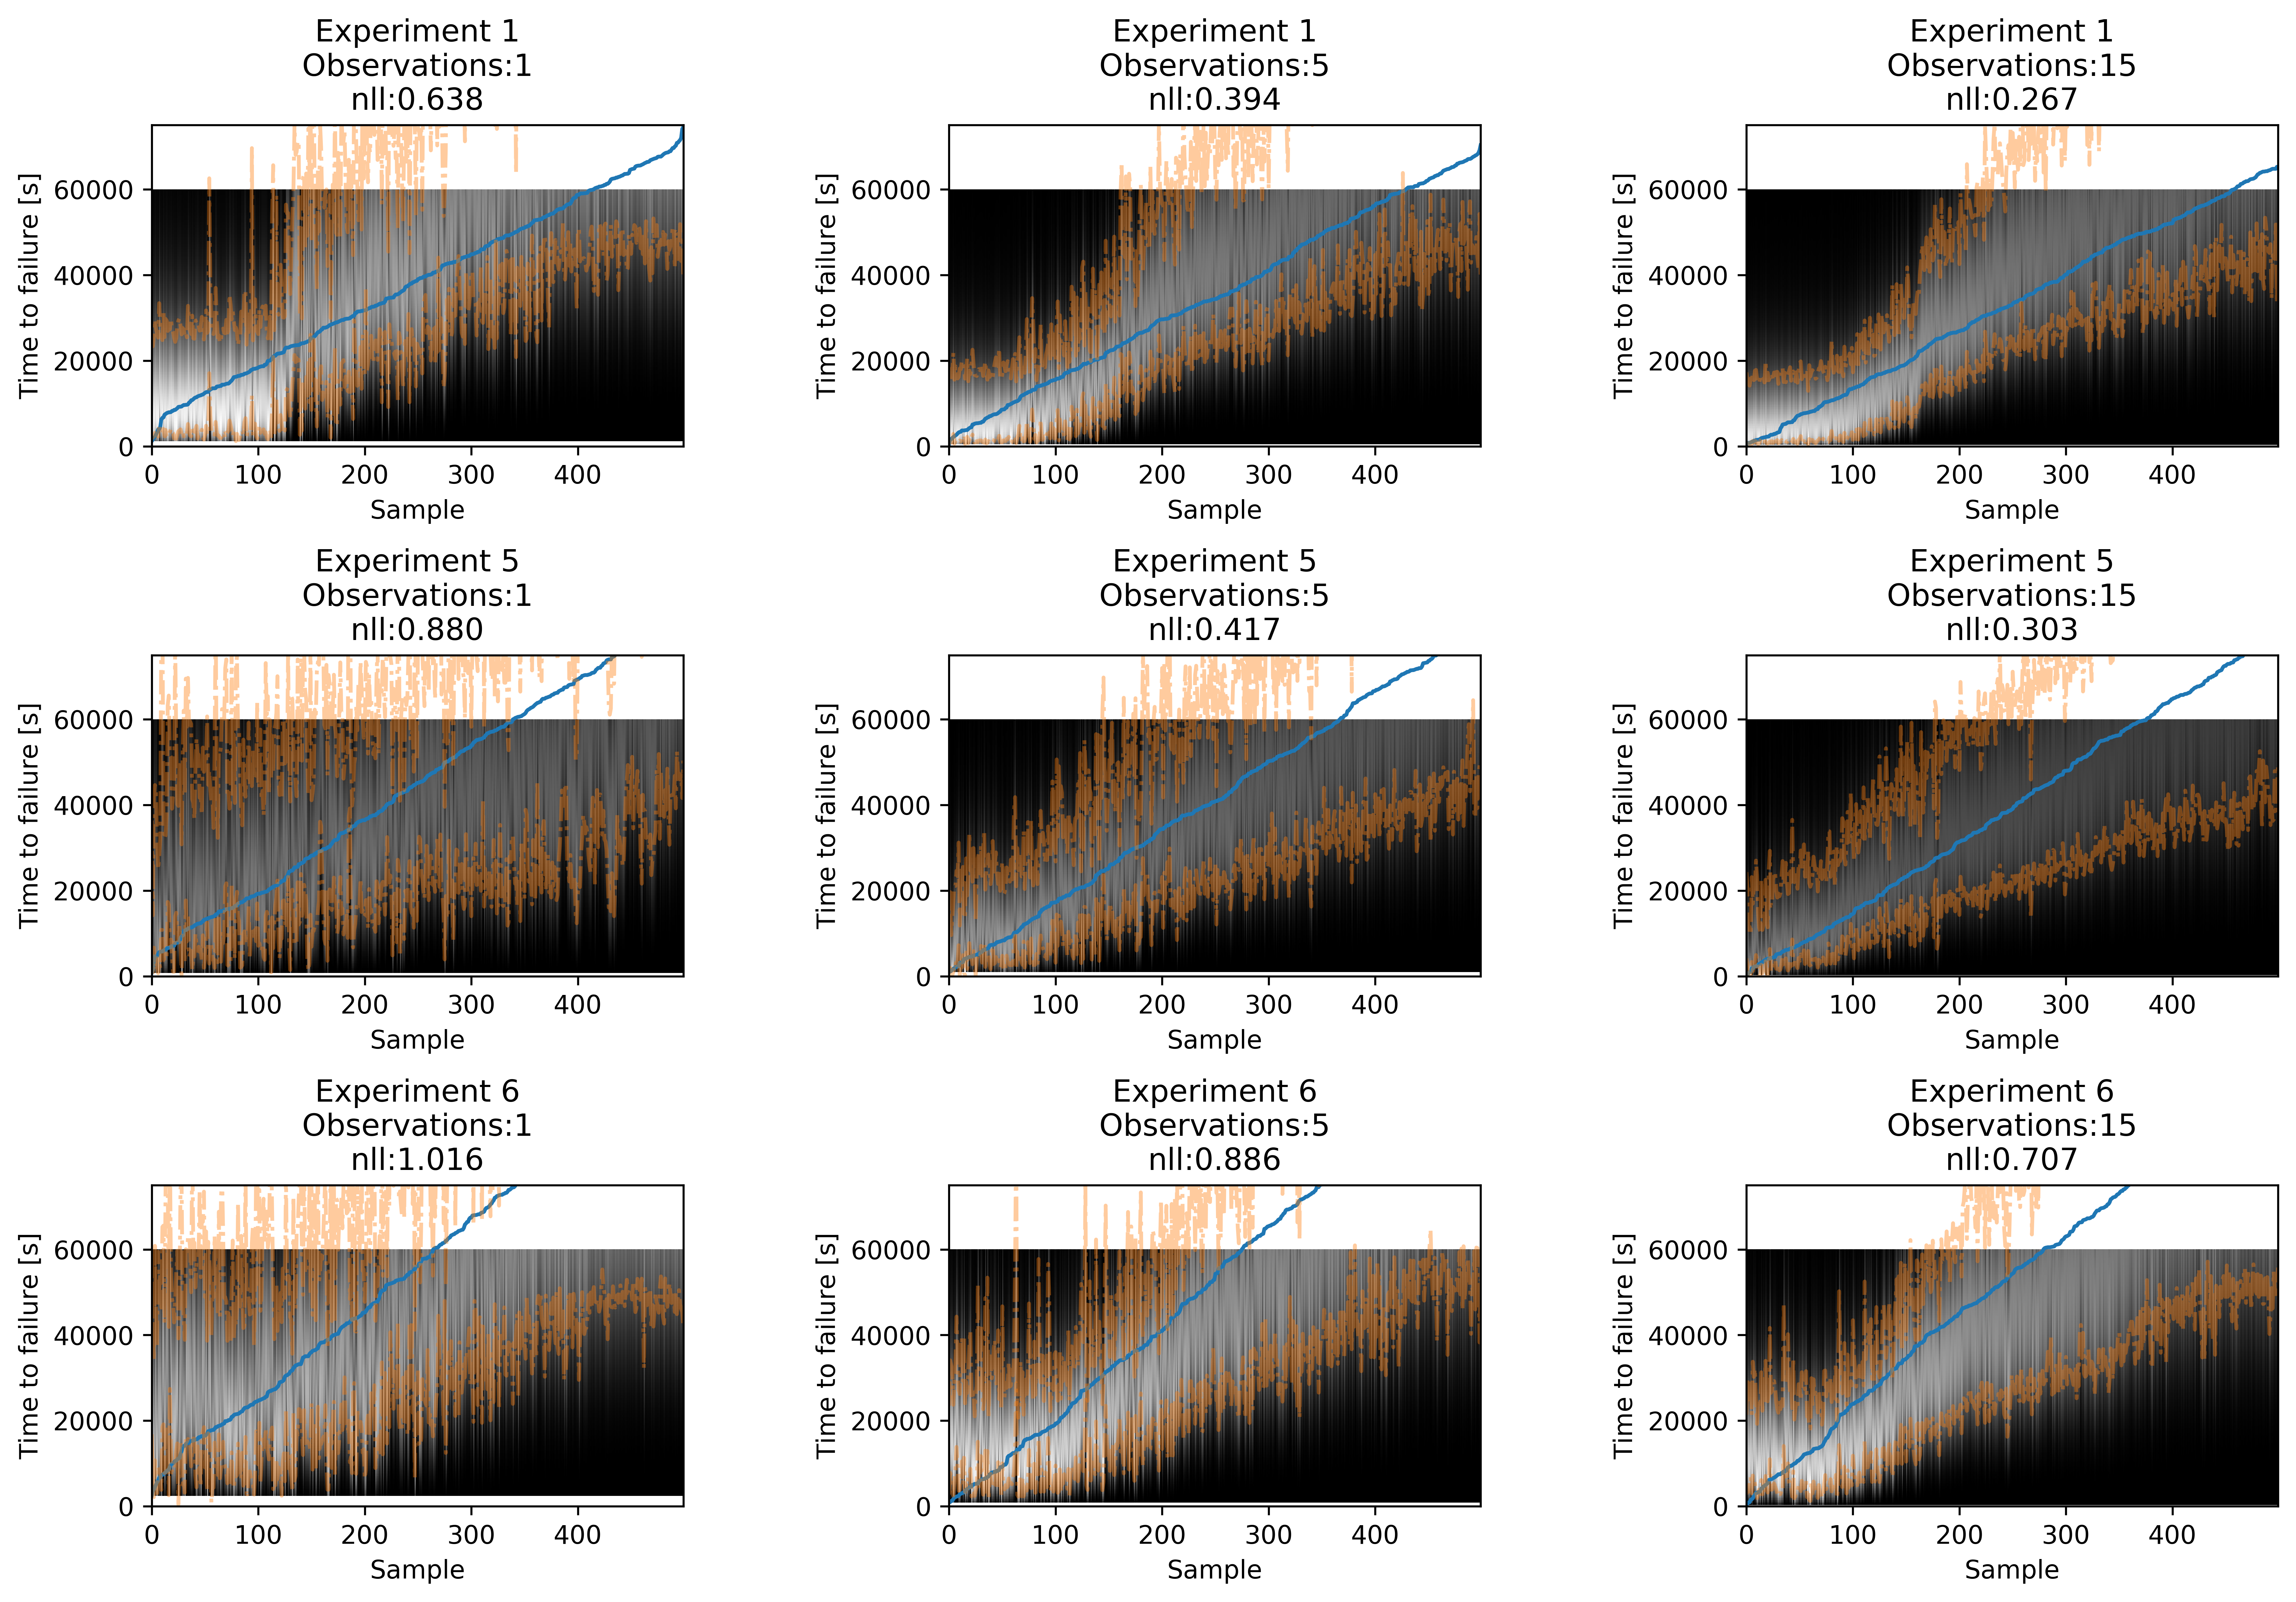

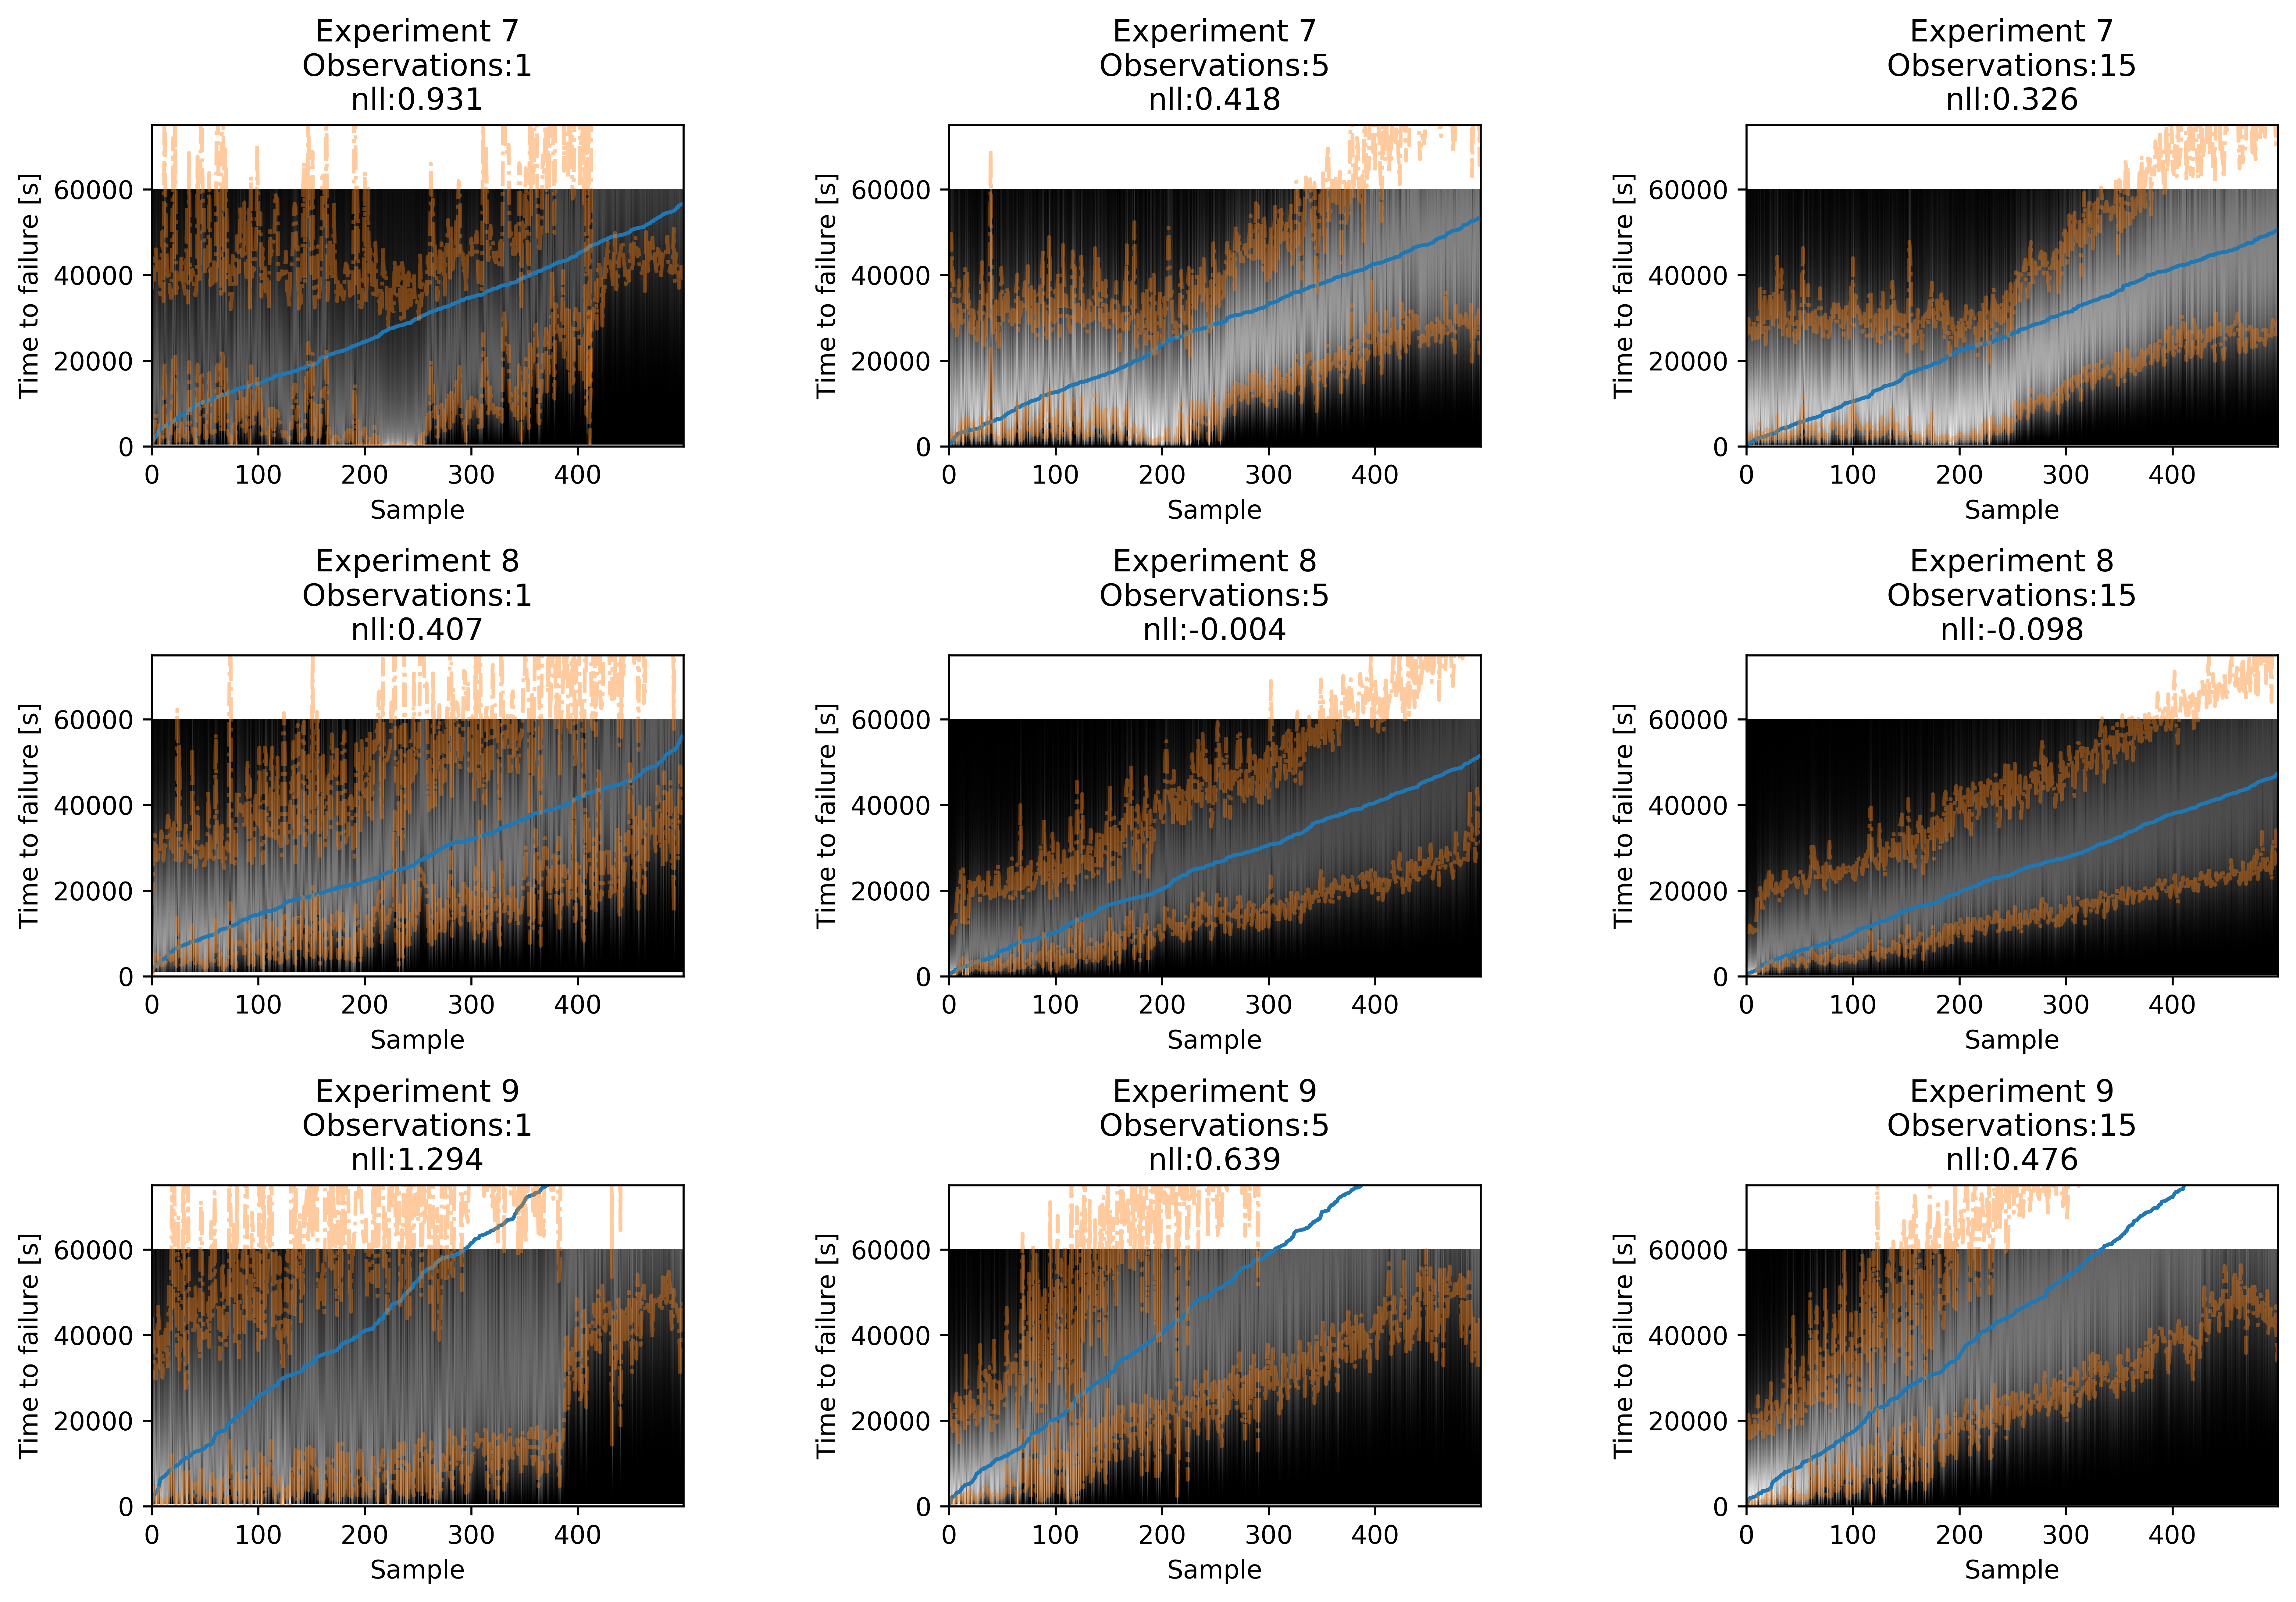

In [49]:

plot_experiments(inds_exp_source[0:3])
plot_experiments(inds_exp_source[3:6])

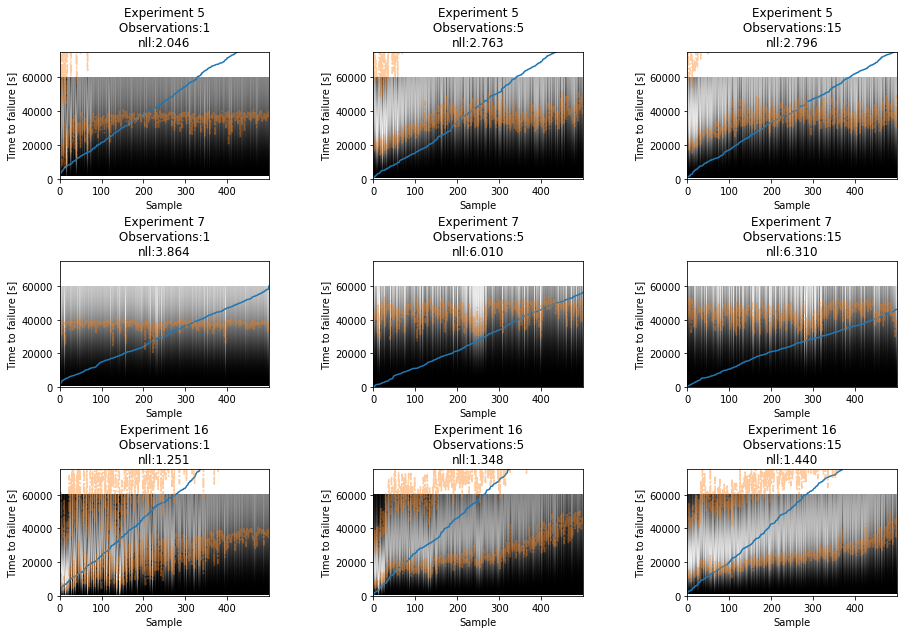

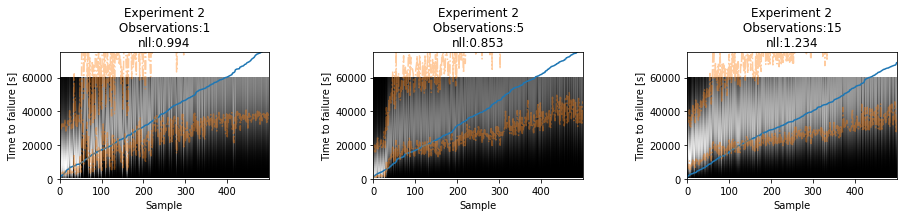

In [227]:

plot_experiments(inds_exp_target[0:3])
plot_experiments(inds_exp_target[3:])


In [119]:

inds_exp_target

[5, 7, 16, 2]

In [715]:

inds_exp_target

[5, 7, 16, 2]

In [717]:
gn